# Default Final Project

Author: Haojun Li

The structure of the project will be divided up into 3 categories:
1. EDA to learn interesting structures about the data
2. Defining environments and how to interact with the environment
3. Defining policy evaluation methods
4. Defining baselines
5. Defining Contextual UBC
6. Defining Supervised methods (SVM! Neural networks)

## EDA

Here we will fist run some exploratory analysis on the data

In [96]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
import scipy
import scipy.stats as st
from multiprocessing import Pool
from tqdm import tqdm, trange

In [2]:
df = pd.read_csv('data/warfarin.csv', dtype=str)
df = df.iloc[:5700, :63]
df = df[~df['Therapeutic Dose of Warfarin'].isna()]
df['Height (cm)'] = df['Height (cm)'].astype(float)
df['Height (cm)'] = df['Height (cm)'].fillna(df['Height (cm)'].mean())
df['Weight (kg)'] = df['Weight (kg)'].astype(float)
df['Weight (kg)'] = df['Weight (kg)'].fillna(df['Weight (kg)'].mean())
for column in df.columns:
    if column not in ['Height (cm)', 'Weight (kg)']:
        df[column] = df[column].fillna('Unknown')
df['Therapeutic Dose of Warfarin'] = df['Therapeutic Dose of Warfarin'].astype(float)
df['Therapeutic Dose of Warfarin (categorized)'] = pd.cut(df['Therapeutic Dose of Warfarin'], 
    [0, 20.99999, 49, max(df['Therapeutic Dose of Warfarin'])],
    labels=['low', 'medium', 'high'])
df = df.drop(columns=['INR on Reported Therapeutic Dose of Warfarin', 'Subject Reached Stable Dose of Warfarin'])

In [3]:
df['Age decades'] = 0
for cat in df['Age'].unique():
    decade = 0
    if cat == '10 - 19':
        decade = 1
    elif cat == '20 - 29':
        decade = 2
    elif cat == '30 - 39':
        decade = 3
    elif cat == '40 - 49':
        decade = 4
    elif cat == '50 - 59':
        decade = 5
    elif cat == '60 - 69':
        decade = 6
    elif cat == '70 - 79':
        decade = 7
    elif cat == '80 - 89':
        decade = 8
    elif cat == '90+':
        decade = 9
    else:
        continue
    df.loc[df['Age'] == cat, 'Age decades'] = decade
df.loc[df['Age'].isna(), 'Age decades'] = 7 # this is the mode imputed

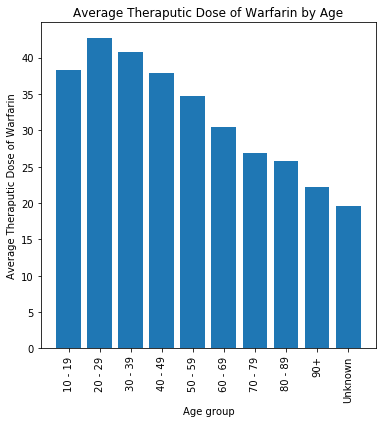

In [216]:
plt.figure(figsize=(6, 6))
means = df.groupby('Age').mean()['Therapeutic Dose of Warfarin']
x = list(means.index) + ['Unknown Age']
y = list(means.values.flatten()) + [df[df['Age'].isna()]['Therapeutic Dose of Warfarin'].mean()]
plt.bar(x, y)
plt.title('Average Theraputic Dose of Warfarin by Age')
plt.xlabel('Age group')
plt.ylabel('Average Theraputic Dose of Warfarin')
plt.xticks(rotation=90)
plt.savefig('plots/dose_vs_age_group.png')

## Define features and Encoding

Here we select the features that we want and define a way of encoding them. These will be used throught the rest of the notebook

In [5]:
uniques = {column : list(df[column].unique()) for column in df.columns}
def encode(state, lst_features):
    state = state[lst_features]
    vec = []
    for index in state.index:
        if index in ['Height (cm)', 'Weight (kg)', 'Age decades']:
            vec += [state[index]]
        else:
            possible_values = uniques[index]
            vec += [1 if possible_value == state[index] else 0 for possible_value in possible_values]
    return vec

In [6]:
# df.columns

In [7]:
len(encode(df.iloc[0], ['Race', 'Age decades',
            'Height (cm)', 'Weight (kg)', 'Carbamazepine (Tegretol)', 
            'Amiodarone (Cordarone)','Phenytoin (Dilantin)', 'Rifampin or Rifampicin']))

19

In [8]:
len(encode(df.iloc[0], ['Gender', 'Race', 'Ethnicity', 'Age decades',
        'Height (cm)', 'Weight (kg)', 'Indication for Warfarin Treatment', 'Diabetes',
        'Congestive Heart Failure and/or Cardiomyopathy', 'Valve Replacement',
        'Aspirin', 'Acetaminophen or Paracetamol (Tylenol)',
        'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day',
        'Simvastatin (Zocor)', 'Atorvastatin (Lipitor)', 'Fluvastatin (Lescol)',
        'Lovastatin (Mevacor)', 'Pravastatin (Pravachol)',
        'Rosuvastatin (Crestor)', 'Cerivastatin (Baycol)',
        'Amiodarone (Cordarone)', 'Carbamazepine (Tegretol)',
        'Phenytoin (Dilantin)', 'Rifampin or Rifampicin',
        'Sulfonamide Antibiotics', 'Macrolide Antibiotics',
        'Anti-fungal Azoles', 'Herbal Medications, Vitamins, Supplements',
        'Target INR', 'Estimated Target INR Range Based on Indication', 'Current Smoker',]))

152

## Calculate true parameters

To find the "gold" parameters for each arm, since we constructed the problem as linear bandits, we will find the "gold" parameters as a linear regression on predicting the reward (0 for correct dosage, -1 for wrong dosage). We will find a beta for each arm independently.

In [9]:
feature_names = ['Race', 'Age decades',
            'Height (cm)', 'Weight (kg)', 'Carbamazepine (Tegretol)', 
            'Amiodarone (Cordarone)','Phenytoin (Dilantin)', 'Rifampin or Rifampicin']
# feature_names = ['Gender', 'Race', 'Ethnicity', 'Age decades',
#         'Height (cm)', 'Weight (kg)', 'Indication for Warfarin Treatment', 'Diabetes',
#         'Congestive Heart Failure and/or Cardiomyopathy', 'Valve Replacement',
#         'Aspirin', 'Acetaminophen or Paracetamol (Tylenol)',
#         'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day',
#         'Simvastatin (Zocor)', 'Atorvastatin (Lipitor)', 'Fluvastatin (Lescol)',
#         'Lovastatin (Mevacor)', 'Pravastatin (Pravachol)',
#         'Rosuvastatin (Crestor)', 'Cerivastatin (Baycol)',
#         'Amiodarone (Cordarone)', 'Carbamazepine (Tegretol)',
#         'Phenytoin (Dilantin)', 'Rifampin or Rifampicin',
#         'Sulfonamide Antibiotics', 'Macrolide Antibiotics',
#         'Anti-fungal Azoles', 'Herbal Medications, Vitamins, Supplements',
#         'Target INR', 'Estimated Target INR Range Based on Indication', 'Current Smoker']
X = df.apply(lambda row: encode(row, feature_names), 1, True)
X = np.array(X.to_list())
y_low = (df['Therapeutic Dose of Warfarin (categorized)'] == 'low').to_numpy() - 1
y_medium = (df['Therapeutic Dose of Warfarin (categorized)'] == 'medium').to_numpy() - 1
y_high = (df['Therapeutic Dose of Warfarin (categorized)'] == 'high').to_numpy() - 1

In [10]:
from sklearn.linear_model import LinearRegression
linear_low = LinearRegression(fit_intercept=False).fit(X, y_low)
linear_medium = LinearRegression(fit_intercept=False).fit(X, y_medium)
linear_high = LinearRegression(fit_intercept=False).fit(X, y_high)

In [11]:
low_mse = np.mean(np.power(X.dot(linear_low.coef_.T) - y_low, 2))
medium_mse = np.mean(np.power(X.dot(linear_medium.coef_.T) - y_medium, 2))
high_mse = np.mean(np.power(X.dot(linear_high.coef_.T) - y_high, 2))
print(f'low MSE is {low_mse}, medium MSE is {medium_mse}, high MSE is {high_mse}')

low MSE is 0.16698271278610421, medium MSE is 0.2317222747466462, high MSE is 0.08958474712162273


## Regret

Here we calculate regret. Since regret is independent on the policy used, we can find the total emparical regret using the "gold" betas we found above as well as the true and predicted arm for each round.

In [14]:
def get_coef(action, low_beta, medium_beta, high_beta):
    if action == 'low':
        return low_beta
    if action == 'medium':
        return medium_beta
    if action == 'high':
        return high_beta

def regret(state, action, low_beta, medium_beta, high_beta):
    x = np.array(encode(state, feature_names)).reshape(1, -1)
    best_linear_reward = np.max([x.dot(beta.T)[0] for beta in [low_beta, medium_beta, high_beta]])
    coef = get_coef(action, low_beta, medium_beta, high_beta)
    regret = best_linear_reward - x.dot(coef.T)
    return regret[0]

print(regret(df.iloc[0], 'high', linear_low.coef_, linear_medium.coef_, linear_high.coef_))

def batch_regret(states, actions, low_beta, medium_beta, high_beta):
    all_actions = ['low', 'medium', 'high']
    X = states.apply(lambda row: encode(row, feature_names), 1, True)
    X = np.array(X.to_list())
    betas = np.hstack([low_beta.reshape(-1, 1), medium_beta.reshape(-1, 1), high_beta.reshape(-1, 1)])
    linear_rewards = X.dot(betas)
    actions_numeric = [all_actions.index(action) for _, action in enumerate(actions)]
    regrets = np.max(linear_rewards, 1) - linear_rewards[list(range(linear_rewards.shape[0])), actions_numeric]
    return regrets

print(batch_regret(df.iloc[0:3], ['high', 'high', 'high'], 
                   linear_low.coef_, linear_medium.coef_, linear_high.coef_ ))

0.44495939102318893
[0.44495939 0.2854361  0.47281279]


In [15]:
def simulate(df, policy, linear_low=linear_low, linear_medium=linear_medium, linear_high=linear_high, bar=True):
    permuted_df = df.sample(frac=1)
    states = permuted_df.drop(columns=['PharmGKB Subject ID', 'Therapeutic Dose of Warfarin', 'Therapeutic Dose of Warfarin (categorized)'])
    labels = permuted_df['Therapeutic Dose of Warfarin (categorized)']
    total_reward = 0
    actions = []
    rewards = []
    if bar:
        t = trange(len(states.index))
    else:
        t = range(len(states.index))
    for i in t:
        state = states.iloc[i]
        label = labels.iloc[i]
        action = policy.get_action(state)
        reward = 0 if action == label else -1
        policy.update_policy(state, action, reward, label)
        total_reward += reward
        actions += [action]
        rewards += [reward]
        if bar:
            t.set_postfix(total_reward = total_reward)
    regrets = batch_regret(states, actions, linear_low.coef_, linear_medium.coef_, linear_high.coef_)
    return actions, rewards, regrets

In [16]:
fixed_actions, fixed_rewards, fixed_regret = simulate(df, FixedDosePolicy('medium'))

100%|██████████| 5528/5528 [00:08<00:00, 650.32it/s, total_reward=-2146]


In [17]:
clinical_actions, clinical_rewards, clinical_regret = simulate(df, ClinicalDosingAlgorithm())

100%|██████████| 5528/5528 [00:09<00:00, 599.58it/s, total_reward=-1975]


In [18]:
fixed_regret.sum()

61.532225965119686

In [82]:
clinical_regret.sum()

54.227495125882854

In [83]:
len(clinical_regret)

5528

## Baselines

Here we define the baselines

In [68]:
class FixedDosePolicy(object):
    
    def __init__(self, dose):
        self.dose = dose
        
    def get_action(self, state):
        return self.dose
    
    def update_policy(self, state, action, reward, true_label):
        return

fixed_actions, fixed_rewards, fixed_regrets = simulate(df, FixedDosePolicy('medium'))

100%|██████████| 5528/5528 [00:06<00:00, 843.80it/s, total_reward=-2146]


In [69]:
sum(fixed_regrets)

61.53222596511968

In [151]:
-np.mean(fixed_rewards)

0.388205499276411

In [149]:
class ClinicalDosingAlgorithm(object):
    
    def get_action(self, state):
        dose = 4.0376
        dose += - 0.2546 * state['Age decades']
        dose += 0.0118 * state['Height (cm)']
        dose += 0.0134 * state['Weight (kg)']
        if state['Race'] == 'Asian':
            dose += - 0.6752
        if state['Race'] == 'Black or African American':
            dose += 0.4060
        if state['Race'] == 'Unknown':
            dose += 0.0443
        if state['Carbamazepine (Tegretol)'] == '1' or state['Phenytoin (Dilantin)'] == '1'\
                or state['Rifampin or Rifampicin'] == '1':
            dose += 1.2799
        if state['Amiodarone (Cordarone)'] == '1':
            dose += -0.5695
        dose = dose ** 2
        if dose < 21:
            return 'low'
        if dose < 49:
            return 'medium'
        return 'high'
    
    def update_policy(self, state, action, reward, true_label):
        return
clinical_actions, clinical_rewards, clinical_regrets = simulate(df, ClinicalDosingAlgorithm())

100%|██████████| 5528/5528 [00:08<00:00, 641.31it/s, total_reward=-1975]


In [152]:
np.sum(clinical_regrets)

54.227495125882854

In [153]:
-np.mean(clinical_rewards)

0.35727206946454415

## Defining Linear UCB Policy

Here we will use Disjoint Liner UCB since the assumption for it is quite nice. There is no additional context per action, but rather we have the exact same context for each arm (namely the patient features). 

In [19]:
class LinUCBDisjoint(object):
    
    def __init__(self, alpha, feature_names, actions, d):
        self.alpha = alpha
        self.feature_names = feature_names
        self.actions = actions
        self.As = [np.eye(d) for _ in range(len(actions))]
        self.bs = [np.zeros((d, 1)) for _ in range(len(actions))]
        
    def featurize(self, state):
        return np.array(encode(state, self.feature_names)).reshape(-1, 1)
        
    def get_action(self, state):
        ps = []
        x = self.featurize(state)
        for a in range(3):
            A_inv = np.linalg.inv(self.As[a])
            theta = A_inv.dot(self.bs[a])
            ps += [x.T.dot(theta)[0, 0] + self.alpha * np.sqrt(x.T.dot(A_inv).dot(x))[0, 0]]
        a_t = np.argmax(ps)
        return self.actions[a_t]
    
    def update_policy(self, state, action, reward, true_label):
        x = self.featurize(state)
        self.As[self.actions.index(action)] += x.dot(x.T)
        self.bs[self.actions.index(action)] += reward * x

policy = LinUCBDisjoint(np.sqrt(np.log(2 / 0.1)/2), 
                        feature_names, ['low', 'medium', 'high'], len(encode(df.iloc[0], feature_names)))
rl_actions, rl_rewards, rl_regret = simulate(df, policy)

100%|██████████| 5528/5528 [00:21<00:00, 259.48it/s, total_reward=-2035]


In [20]:
print(f'disjoint linear UCB is able to achieve {rl_regret.sum()} regret')

disjoint linear UCB is able to achieve 81.1333582749707 regret


## Hyperparameter search


In [63]:
alphas = [np.sqrt(np.log(2 / 0.1)/2) * i * 0.25 for i in range(15)]
all_results = {}
for alpha in alphas:
    d = len(encode(df.iloc[0], feature_names))
    results = []
    for i in range(20):
        print(f'running experiment for {alpha} iteration {i}')
        policy = LinUCBDisjoint(alpha, feature_names, ['low', 'medium', 'high'], d)
        results += [simulate(df, policy, bar=False)]
    all_results[alpha] = results

running experiment for 0.0 iteration 0
running experiment for 0.0 iteration 1
running experiment for 0.0 iteration 2
running experiment for 0.0 iteration 3
running experiment for 0.0 iteration 4
running experiment for 0.0 iteration 5
running experiment for 0.0 iteration 6
running experiment for 0.0 iteration 7
running experiment for 0.0 iteration 8
running experiment for 0.0 iteration 9
running experiment for 0.0 iteration 10
running experiment for 0.0 iteration 11
running experiment for 0.0 iteration 12
running experiment for 0.0 iteration 13
running experiment for 0.0 iteration 14
running experiment for 0.0 iteration 15
running experiment for 0.0 iteration 16
running experiment for 0.0 iteration 17
running experiment for 0.0 iteration 18
running experiment for 0.0 iteration 19
running experiment for 0.30596835383510207 iteration 0
running experiment for 0.30596835383510207 iteration 1
running experiment for 0.30596835383510207 iteration 2
running experiment for 0.30596835383510207 it

running experiment for 2.1417784768457144 iteration 16
running experiment for 2.1417784768457144 iteration 17
running experiment for 2.1417784768457144 iteration 18
running experiment for 2.1417784768457144 iteration 19
running experiment for 2.4477468306808166 iteration 0
running experiment for 2.4477468306808166 iteration 1
running experiment for 2.4477468306808166 iteration 2
running experiment for 2.4477468306808166 iteration 3
running experiment for 2.4477468306808166 iteration 4
running experiment for 2.4477468306808166 iteration 5
running experiment for 2.4477468306808166 iteration 6
running experiment for 2.4477468306808166 iteration 7
running experiment for 2.4477468306808166 iteration 8
running experiment for 2.4477468306808166 iteration 9
running experiment for 2.4477468306808166 iteration 10
running experiment for 2.4477468306808166 iteration 11
running experiment for 2.4477468306808166 iteration 12
running experiment for 2.4477468306808166 iteration 13
running experiment f

In [79]:
# import pickle
# with open('all_results.pk', 'wb') as f:
#     pickle.dump(all_results, f)

In [80]:
import pickle
with open('all_results.pk', 'rb') as f:
    all_results = pickle.load(f)

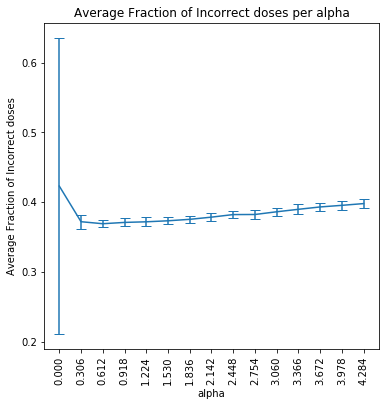

In [161]:
alphas = sorted(list(all_results.keys()))
incorrect_frac = [np.mean([-np.mean(rewards) for _, rewards, _ in all_results[alpha]]) for alpha in alphas]
incorrect_frac_std = [np.std([-np.mean(rewards) for _, rewards, _ in all_results[alpha]]) for alpha in alphas]
plt.figure(figsize=(6, 6))
plt.errorbar(alphas, incorrect_frac, yerr=[2*std for std in incorrect_frac_std], markersize=4, capsize=5)
plt.title('Average Fraction of Incorrect doses per alpha')
plt.xlabel('alpha')
plt.ylabel('Average Fraction of Incorrect doses')
plt.xticks(alphas, rotation=90)
plt.savefig('plots/Avg_frac_incorrect_alpha.png')

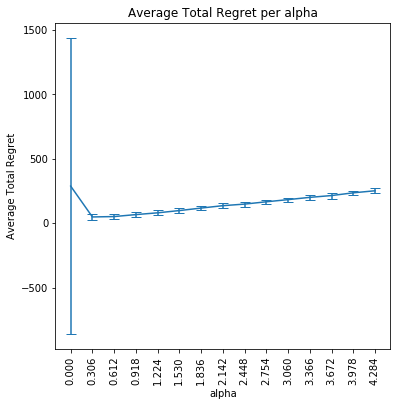

In [163]:
alphas = sorted(list(all_results.keys()))
regrets = [np.mean([np.sum(regrets) for _, _, regrets in all_results[alpha]]) for alpha in alphas]
regrets_std = [np.std([np.sum(regrets) for _, _, regrets in all_results[alpha]]) for alpha in alphas]
plt.figure(figsize=(6, 6))
plt.errorbar(alphas, regrets, yerr=[2*std for std in regrets_std], markersize=4, capsize=5)
plt.title('Average Total Regret per alpha')
plt.xlabel('alpha')
plt.ylabel('Average Total Regret')
plt.xticks(alphas, rotation=90)
plt.savefig('plots/avg_tot_regret_alpha.png')

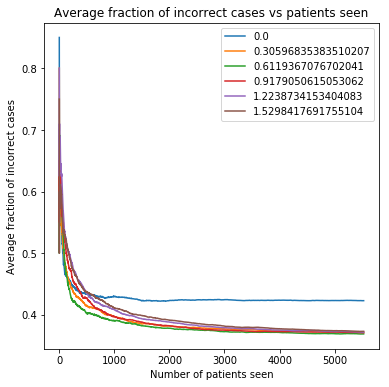

In [205]:
alphas = sorted(list(all_results.keys()))[0:6]
plt.figure(figsize=(6, 6))
for alpha in alphas:
    alpha_rewards = np.vstack([rewards for _, rewards, _ in all_results[alpha]])
    alpha_fracs = (-np.cumsum(alpha_rewards, 1) / np.arange(1, df.shape[0] + 1))
    alpha_means = np.mean(alpha_fracs, 0)
    alpha_stds = np.std(alpha_fracs, 0)
    plt.plot(range(df.shape[0]), alpha_means)
plt.legend(alphas)
plt.xlabel('Number of patients seen')
plt.ylabel('Average fraction of incorrect cases')
plt.title('Average fraction of incorrect cases vs patients seen')
plt.savefig('plots/avg_frac_alphas.png')

In [191]:
alpha_means

array([1.53762663e-04, 2.44211288e-04, 3.70839363e-04, ...,
       4.22928726e-01, 4.22982996e-01, 4.23082489e-01])

In [89]:
alphas[2]

0.6119367076702041

In [90]:
regrets[2]

51.44991674527547

In [88]:
incorrect_frac[2]

0.3691570188133141

## Plotting t-distribution 



In [92]:
import scipy.stats as st
results = []
alpha = 0.6119367076702041
for i in range(20):
    print(f'running experiment for {alpha} iteration {i}')
    policy = LinUCBDisjoint(alpha, feature_names, ['low', 'medium', 'high'], d)
    results += [simulate(df, policy, bar=False)]

running experiment for 0.6119367076702041 iteration 0
running experiment for 0.6119367076702041 iteration 1
running experiment for 0.6119367076702041 iteration 2
running experiment for 0.6119367076702041 iteration 3
running experiment for 0.6119367076702041 iteration 4
running experiment for 0.6119367076702041 iteration 5
running experiment for 0.6119367076702041 iteration 6
running experiment for 0.6119367076702041 iteration 7
running experiment for 0.6119367076702041 iteration 8
running experiment for 0.6119367076702041 iteration 9
running experiment for 0.6119367076702041 iteration 10
running experiment for 0.6119367076702041 iteration 11
running experiment for 0.6119367076702041 iteration 12
running experiment for 0.6119367076702041 iteration 13
running experiment for 0.6119367076702041 iteration 14
running experiment for 0.6119367076702041 iteration 15
running experiment for 0.6119367076702041 iteration 16
running experiment for 0.6119367076702041 iteration 17
running experiment f

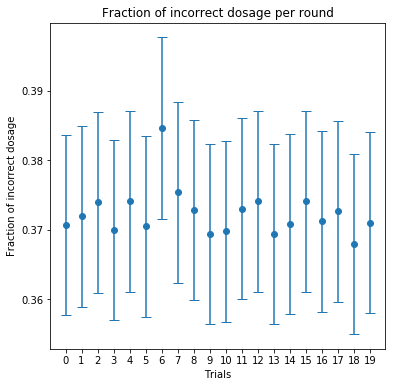

In [156]:
reward_means = np.array([-np.mean(rewards) for actions, rewards, regrets in results])
reward_t_interval = np.array([st.t.std(len(rewards) - 1, loc=np.mean(rewards), scale=st.sem(rewards)) \
                      for actions, rewards, regrets in results])
plt.figure(figsize=(6, 6))
plt.errorbar(range(len(reward_means)), reward_means, yerr=reward_t_interval * 2, fmt='o', capsize=5)
plt.title('Fraction of incorrect dosage per round')
plt.xlabel('Trials')
plt.ylabel('Fraction of incorrect dosage')
plt.xticks(range(20))
plt.savefig('plots/frac_incorrect_dosage_t.png')

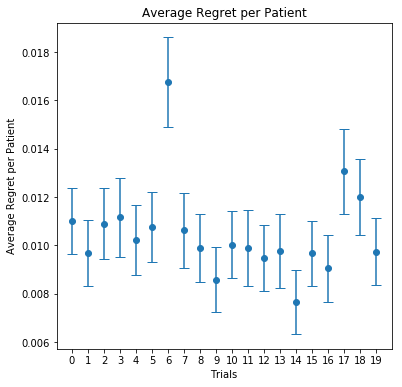

In [155]:
regret_means = np.array([np.mean(regrets) for actions, rewards, regrets in results])
regret_t_interval = np.array([st.t.std(len(regrets) - 1, loc=np.mean(regrets), scale=st.sem(regrets)) \
                      for actions, rewards, regrets in results])
plt.figure(figsize=(6, 6))
plt.errorbar(range(len(regret_means)), regret_means, yerr=regret_t_interval * 2, fmt='o', capsize=5)
plt.title('Average Regret per Patient')
plt.xticks(range(20))
plt.xlabel('Trials')
plt.ylabel('Average Regret per Patient')
plt.savefig('plots/avg_regret_per_t.png')

## Supervised

A supervised approach allows us to have an emparical upper bound on the performance of reinforcement learning algorithms

### Theoretical limit of SVM

Here we would like to know what is the optimal possible value for the SVM and logistic regression

In [24]:
y = y_low * 0 + (1 + y_medium) * 1 + (1 + y_high) * 2

In [164]:
classifier = sklearn.linear_model.LogisticRegression(n_jobs=8, max_iter=5000).fit(X, y)
predicted_actions = classifier.predict(X)
reward = -np.sum(predicted_actions != y)0.3538
print(f'Logistic Regression could achieve maximum {reward} reward')

Logistic Regression could achieve maximum -1956 reward


In [169]:
np.sum(batch_regret(df, np.array(['low', 'medium', 'high'])[predicted_actions], linear_low.coef_, linear_medium.coef_, linear_high.coef_))

30.930929769165694

In [170]:
classifier = sklearn.svm.SVC().fit(X, y)
predicted_actions = classifier.predict(X)
reward = -np.sum(predicted_actions != y)
print(f'SVC could achieve maximum {reward} reward')

SVC could achieve maximum -2146 reward


In [171]:
np.sum(batch_regret(df, np.array(['low', 'medium', 'high'])[predicted_actions], linear_low.coef_, linear_medium.coef_, linear_high.coef_))

61.53222596511969

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [31]:
class Supervised(object):
    
    def __init__(self, batch_size, feature_names, actions):
        self.classifier = sklearn.linear_model.LogisticRegression(n_jobs=8, max_iter=5000)
        self.initialized = False
        self.actions = actions
        self.batch_size = batch_size
        self.feature_names = feature_names
        self.data = []
        self.labels = []
        
    def featurize(self, state):
        return np.array(encode(state, self.feature_names))
    
    def get_action(self, state):
        s = self.featurize(state)
        if self.initialized:
            prediction = self.classifier.predict(s.reshape(1, -1))
            return self.actions[prediction[0]]
        else:
            return self.actions[1]

    def update_policy(self, state, action, reward, true_label):
        s = self.featurize(state)
        self.data += [s]
        self.labels += [self.actions.index(true_label)]
        if len(self.data) % self.batch_size == 0:
            self.classifier.fit(np.vstack(self.data), self.labels)
            self.initialized = True

supervised_actions, supervised_rewards, supervised_regrets = \
    simulate(df, Supervised(50, feature_names, ['low', 'medium', 'high']))

100%|██████████| 5528/5528 [03:25<00:00, 26.86it/s, total_reward=-1989]


In [32]:
np.sum(supervised_regrets)

33.49420503282495

In [159]:
-np.mean(supervised_rewards)

0.35980463096960924

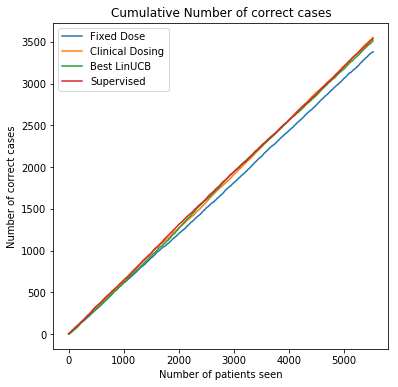

In [175]:
# fixed_rewards, clinical_rewards
horizon = len(fixed_rewards)
best_rl_rewards = max([reward for _, runs in all_results.items() for _, reward, _ in runs], key=np.mean)
plt.figure(figsize=(6, 6))
plt.plot(range(horizon), np.cumsum(1 + np.array(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(clinical_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(best_rl_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(supervised_rewards)))
plt.legend(['Fixed Dose', 'Clinical Dosing', 'Best LinUCB', 'Supervised'])
plt.title('Cumulative Number of correct cases')
plt.xlabel('Number of patients seen')
plt.ylabel('Number of correct cases')
plt.savefig('plots/comparison.png')

In [207]:
d = 19
alpha = 0.6119367076702041

19

In [208]:
supervised_results = [simulate(df, Supervised(50, feature_names, ['low', 'medium', 'high'])) for _ in range(20)]
rl_results = [simulate(df, LinUCBDisjoint(alpha, feature_names, ['low', 'medium', 'high'], d)) for _ in range(20)]
fixed_results = [simulate(df, FixedDosePolicy('medium')) for _ in range(20)]
clinical_results = [simulate(df, ClinicalDosingAlgorithm()) for _ in range(20)]

 61%|██████▏   | 3388/5528 [00:03<00:02, 1030.25it/s, total_reward=-1387]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 80%|███████▉  | 4407/5528 [00:04<00:01, 934.08it/s, total_reward=-1734] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 53%|█████▎    | 2903/5528 [00:02<00:02, 884.58it/s, total_reward=-1151]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
T

In [215]:
np.mean([-np.mean(rewards) for actions, rewards, regrets in supervised_results])

0.36124276410998546

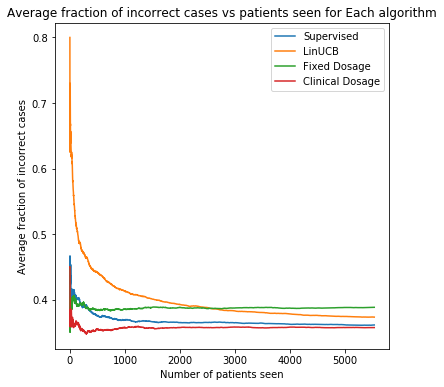

In [209]:
plt.figure(figsize=(6, 6))
for result in [supervised_results, rl_results, fixed_results, clinical_results]:
    rewards = np.vstack([rewards for _, rewards, _ in result])
    fracs = (-np.cumsum(rewards, 1) / np.arange(1, df.shape[0] + 1))
    means = np.mean(fracs, 0)
#     stds = np.std(means, 0)
    plt.plot(range(df.shape[0]), means)
plt.legend(['Supervised', 'LinUCB', 'Fixed Dosage', 'Clinical Dosage'])
plt.xlabel('Number of patients seen')
plt.ylabel('Average fraction of incorrect cases')
plt.title('Average fraction of incorrect cases vs patients seen for Each algorithm')
plt.savefig('plots/avg_frac_algos.png')

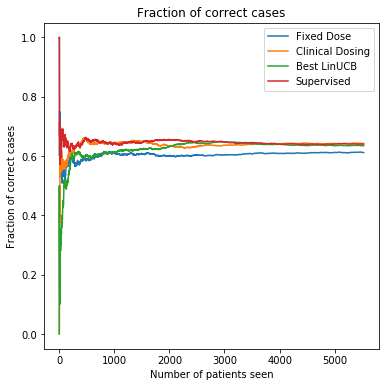

In [176]:
# fixed_rewards, clinical_rewards
horizon = len(fixed_rewards)
best_rl_rewards = max([reward for _, runs in all_results.items() for _, reward, _ in runs], key=np.mean)
plt.figure(figsize=(6, 6))
plt.plot(range(horizon), np.cumsum(1 + np.array(fixed_rewards)) / np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(clinical_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(best_rl_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(supervised_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.legend(['Fixed Dose', 'Clinical Dosing', 'Best LinUCB', 'Supervised'])
plt.title('Fraction of correct cases')
plt.xlabel('Number of patients seen')
plt.ylabel('Fraction of correct cases')
plt.savefig('plots/comparison_frac.png')

In [ ]:
# fixed_rewards, clinical_rewards
horizon = len(fixed_rewards)
best_rl_rewards = max([reward for _, runs in all_results.items() for _, reward, _ in runs], key=np.mean)
plt.figure(figsize=(6, 6))
plt.plot(range(horizon), np.cumsum(1 + np.array(fixed_rewards)) / np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(clinical_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(best_rl_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.plot(range(horizon), np.cumsum(1 + np.array(supervised_rewards))/ np.arange(1, 1+len(fixed_rewards)))
plt.legend(['Fixed Dose', 'Clinical Dosing', 'Best LinUCB', 'Supervised'])
plt.title('Fraction of correct cases')
plt.xlabel('Number of patients seen')
plt.ylabel('Fraction of correct cases')
plt.savefig('plots/comparison_frac.png')